## Tools

In [40]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Dataset

In [41]:
col_names = ['contour number', 'aspect ratio', 'extent', 'Blue', 'Green', 'Red', 'Hue', 'class']
data = pd.read_csv("output.csv", skiprows=1, header=None, names=col_names)
data.head(10)

,contour number,aspect ratio,extent,Blue,Green,Red,Hue,class
0,16,0.850735,0.762296,83.383101,143.296144,143.572600,38.485644,0
1,25,0.626242,0.763346,76.382386,75.957386,85.665909,150.730682,0
2,31,0.628238,0.695970,60.357078,114.183692,136.153077,15.567445,0
3,31,0.896541,0.800835,44.570000,117.787500,134.971667,17.529167,0
4,63,0.693736,0.824233,36.742411,117.234172,135.391154,17.088465,0
5,34,0.928571,0.808913,46.546503,110.883922,126.844989,18.361932,0
6,68,0.979804,0.836557,63.621205,104.295904,104.446747,29.446747,0
7,51,0.760961,0.823015,59.701164,99.514131,103.025769,32.987531,0
8,31,0.957265,0.767948,50.077372,116.466180,137.658394,22.445255,0
9,50,0.828162,0.845766,60.658955,104.919383,113.961094,34.713985,0


## Basic EDA

<AxesSubplot:>

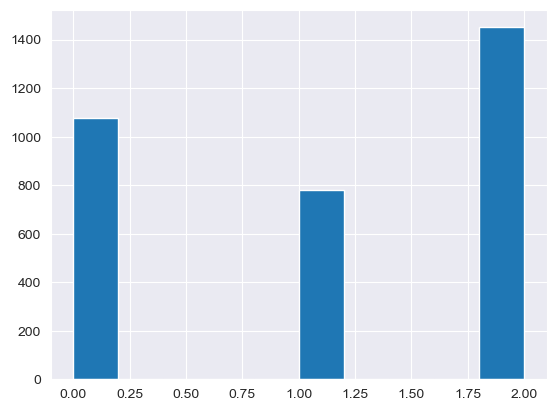

In [42]:
data["class"].hist()

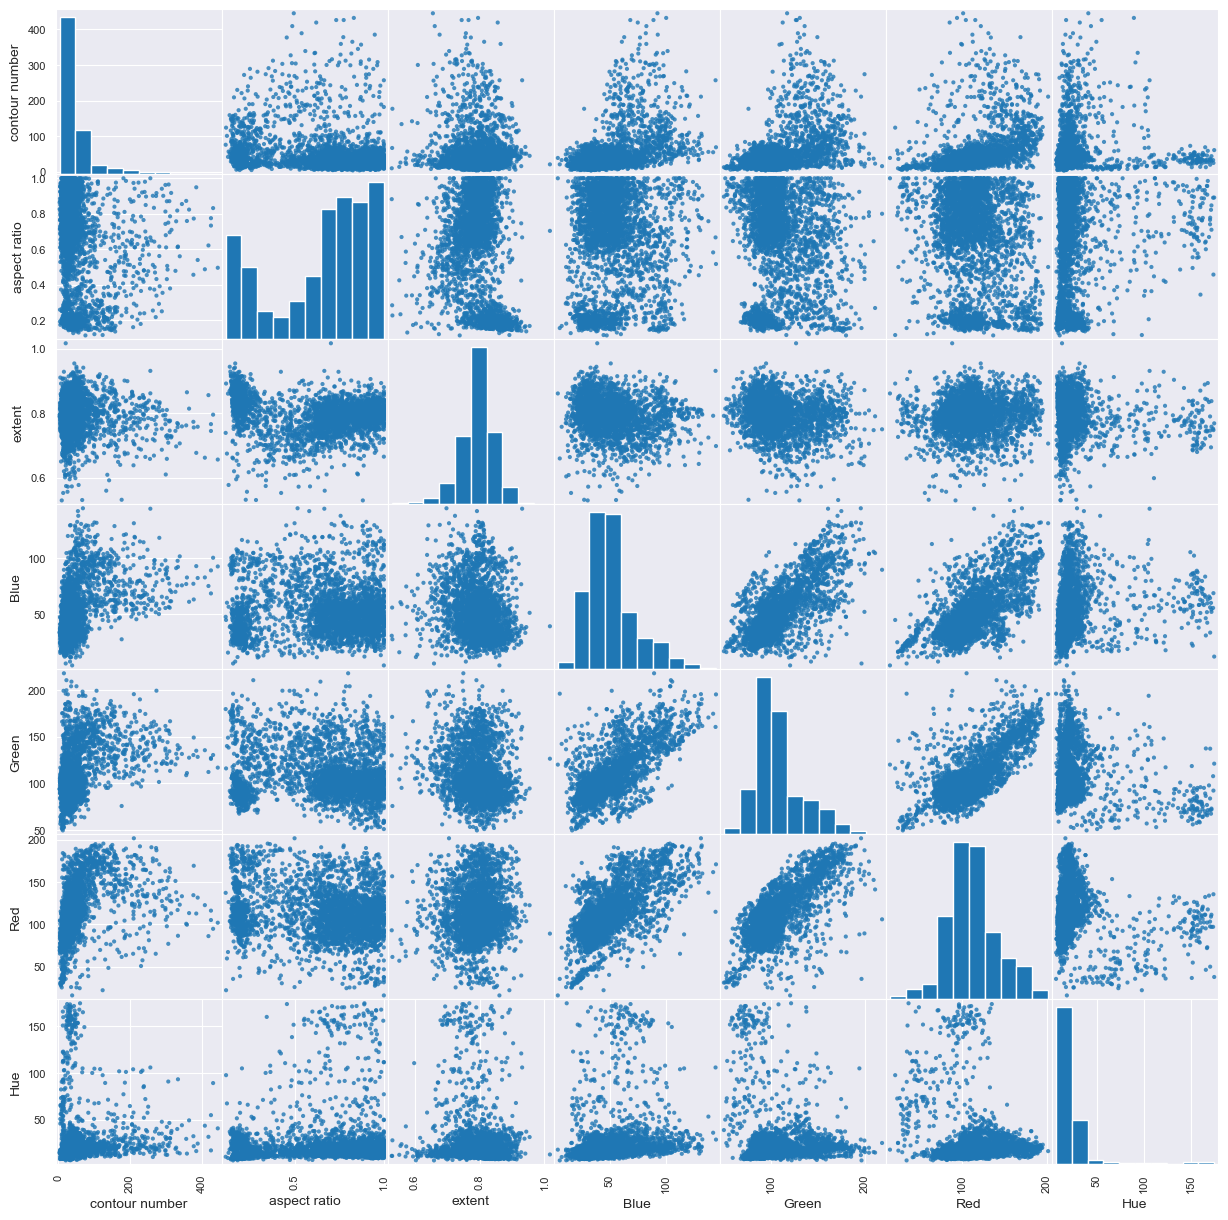

In [43]:
from pandas.plotting import scatter_matrix

# Du kannst hier die gewünschten Merkmale auswählen, abhängig von deinem Datenrahmen
selected_features = ["contour number", "aspect ratio", "extent", "Blue", "Green", "Red", "Hue"]

# Scatter Matrix erstellen
scatter_matrix(data[selected_features], alpha=0.8, figsize=(15, 15), diagonal='hist')

plt.show()


## Calculate P(Y=y) for all possible y

In [44]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [45]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [46]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Gaussian model

In [47]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="class")

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix. ", confusion_matrix(Y_test, Y_pred))
print("F1 Score: ", f1_score(Y_test, Y_pred, average='weighted'))

Accuracy: 0.7326283987915407
Precision: 0.767875926397341
Recall: 0.7326283987915407
Confusion Matrix.  [[ 72  11 139]
 [  3 148   3]
 [ 10  11 265]]
F1 Score:  0.7002293201124762


In [48]:
print(data.columns)


Index(['contour number', 'aspect ratio', 'extent', 'Blue', 'Green', 'Red',
       'Hue', 'class'],
      dtype='object')


## Convert continuous features to Categorical features

In [49]:
data["cat_contour_number"] = pd.cut(data["contour number"].values, bins = 3, labels = [0,1,2])
data["cat_aspect_ratio"] = pd.cut(data["aspect ratio"].values, bins = 3, labels = [0,1,2])
data["cat_extent"] = pd.cut(data["extent"].values, bins = 3, labels = [0,1,2])
data["cat_Blue"] = pd.cut(data["Blue"].values, bins = 3, labels = [0,1,2])
data["cat_Green"] = pd.cut(data["Green"].values, bins = 3, labels = [0,1,2])
data["cat_Red"] = pd.cut(data["Red"].values, bins = 3, labels = [0,1,2])
data["cat_Hue"] = pd.cut(data["Hue"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["contour number", "aspect ratio", "extent", "Blue", "Green", "Red", "Hue"])
data = data[["cat_contour_number",	"cat_aspect_ratio",	"cat_extent", "cat_Blue", "cat_Green", "cat_Red", "cat_Hue", "class"]]
data.head(10)


,cat_contour_number,cat_aspect_ratio,cat_extent,cat_Blue,cat_Green,cat_Red,cat_Hue,class
0,0,2,1,1,1,2,0,0
1,0,1,1,1,0,1,2,0
2,0,1,1,1,1,1,0,0
3,0,2,1,0,1,1,0,0
4,0,1,1,0,1,1,0,0
5,0,2,1,0,1,1,0,0
6,0,2,1,1,0,1,0,0
7,0,2,1,1,0,1,0,0
8,0,2,1,0,1,1,0,0
9,0,2,1,1,0,1,0,0


## Approach 2: Calculate P(X=x|Y=y) categorically

In [50]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [51]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Categorical model

In [52]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="class")

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix. ", confusion_matrix(Y_test, Y_pred))
print("F1 Score: ", f1_score(Y_test, Y_pred, average='weighted'))

Accuracy: 0.7401812688821753
Precision: 0.7610118894504632
Recall: 0.7401812688821753
Confusion Matrix.  [[ 83   9 130]
 [  2 148   4]
 [ 19   8 259]]
F1 Score:  0.7162010022956545
